## 简答题

1. Glorot初始化和He初始化为了解决什么问题 梯度消失和梯度爆炸问题
2. 是否可以将所有权重初始化为相同的值（只要该值是使用He初始化随机选择的） 不可以，会导致每层学的一样。
3. 将偏置项初始化为0可以吗 可以
4. 总结下讨论过的激活函数，并讲述在什么情况下使用它们 二分类使用sigmoid 多分类softmax
5. 如果在使用SGD优化器时将momentum超参数设置得太接近1（例如0.99999)会发生什么情况 学习速度变慢，对梯度变化不敏感
6. 列举三种能产生稀疏模型得方法 relu激活函数，dropout，正则化
7. dropout会减慢训练速度吗？它会减慢推理（即对新实例进行预测）速度吗？MC dropout呢？ 会，dropout会额外计算。不会，推理不dropout。MC dropout会减慢因为推理使用dropout。

## 编程题

在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

加载数据的代码： tf.keras.datasets.cifar10.load_data()

下载失败的解决方案：
1. 下载文件： cifar-10-python.tar.gz （会把文件发群里）
2. 将文件 cifar-10-python.tar.gz 重命名为 cifar-10-batches-py.tar.gz
3. 并复制到类似 C:\Users\某个用户名或者管理员\.keras\datasets 的路径。将 某个用户名或者管理员 替换为你的用户名。如果是 Linux/Macos 系统，则应为 /home/某个用户名或者管理员/.keras/datasets。

In [1]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


In [2]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

In [3]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

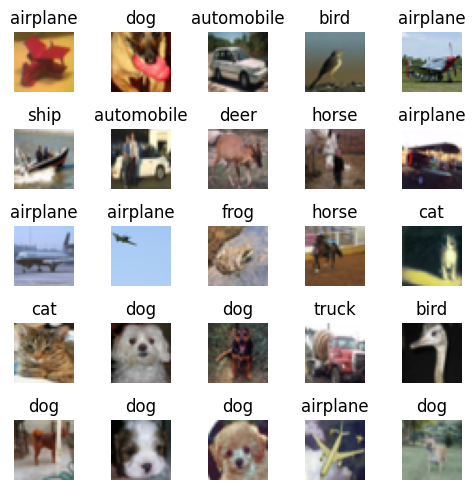

In [4]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

In [5]:
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

class Mymodel(tf.keras.Model):
    def __init__(self, norm=False, activation="swish", dropout_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.mylayers = 20
        self.norm = norm
        self.activation = activation
        self.dropout_rate = dropout_rate
        if self.activation == "swish":
            kernel_initializer = "he_normal"
        else:
            kernel_initializer = "lecun_normal"
        self.kernel_initializer = kernel_initializer

        self.flatten = tf.keras.layers.Flatten()
        self.hidden_layers = []
        for l in range(self.mylayers):
            if self.norm == "BatchNormalization":
                self.hidden_layers.append(tf.keras.layers.BatchNormalization())

            dense = tf.keras.layers.Dense(
                100,
                activation=self.activation,
                kernel_initializer=self.kernel_initializer
            )
            self.hidden_layers.append(dense)

            if self.mylayers*0.4<l and self.dropout_rate > 0:
                dr = np.ceil(self.dropout_rate*(l/self.mylayers) * 100) / 100
                dropout = tf.keras.layers.Dropout(rate=dr)
                self.hidden_layers.append(dropout)

        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs, training=None):
        x = self.flatten(inputs)
        for layer in self.hidden_layers:
            if isinstance(layer, (tf.keras.layers.BatchNormalization, tf.keras.layers.Dropout)):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return self.output_layer(x)

    def build_summary(self):
        self.build((None, 32, 32,3))
        self.summary()
def build_and_train_model(activation="swish", norm=None, dropout_rate=0.0,batch_size=128,
                          X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid):

    model = Mymodel(norm=norm, activation=activation, dropout_rate=dropout_rate)

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        metrics=["accuracy"]
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1)
    ]
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=callbacks
    )
    return model, history

In [6]:
build_and_train_model(activation="swish")

Epoch 1/100
352/352 [==============================] - 10s 19ms/step - loss: 2.1375 - accuracy: 0.1818 - val_loss: 1.9723 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 6s 17ms/step - loss: 1.9255 - accuracy: 0.2757 - val_loss: 1.8486 - val_accuracy: 0.3084 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 6s 18ms/step - loss: 1.8096 - accuracy: 0.3307 - val_loss: 1.7727 - val_accuracy: 0.3638 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 6s 17ms/step - loss: 1.7302 - accuracy: 0.3718 - val_loss: 1.7397 - val_accuracy: 0.3830 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 6s 17ms/step - loss: 1.6845 - accuracy: 0.3903 - val_loss: 1.6421 - val_accuracy: 0.4126 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 6s 17ms/step - loss: 1.6170 - accuracy: 0.4178 - val_loss: 1.6381 - val_accuracy: 0.4112 - lr: 0.0010
Epoch 7/100
352/352 [==============================] - 6s

(<__main__.Mymodel at 0x25831535660>,
 <keras.callbacks.History at 0x258791091e0>)

In [7]:
build_and_train_model(activation="swish", norm="BatchNormalization")

Epoch 1/100
352/352 [==============================] - 23s 46ms/step - loss: 2.1662 - accuracy: 0.2110 - val_loss: 1.9694 - val_accuracy: 0.2918 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 15s 44ms/step - loss: 1.8142 - accuracy: 0.3366 - val_loss: 1.7699 - val_accuracy: 0.3654 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 15s 44ms/step - loss: 1.6825 - accuracy: 0.3933 - val_loss: 1.6695 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 16s 44ms/step - loss: 1.5984 - accuracy: 0.4291 - val_loss: 1.6159 - val_accuracy: 0.4178 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 16s 44ms/step - loss: 1.5253 - accuracy: 0.4558 - val_loss: 1.5563 - val_accuracy: 0.4430 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 15s 44ms/step - loss: 1.4650 - accuracy: 0.4792 - val_loss: 1.5147 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 7/100
352/352 [==============================]

(<__main__.Mymodel at 0x2587e4c2500>,
 <keras.callbacks.History at 0x25831422890>)

In [8]:
build_and_train_model(activation="swish", norm="BatchNormalization", dropout_rate=0.3)

Epoch 1/100
352/352 [==============================] - 28s 52ms/step - loss: 2.4624 - accuracy: 0.1230 - val_loss: 2.2305 - val_accuracy: 0.1636 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 17s 49ms/step - loss: 2.1249 - accuracy: 0.1852 - val_loss: 1.9990 - val_accuracy: 0.2348 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 20s 56ms/step - loss: 1.9913 - accuracy: 0.2324 - val_loss: 1.9062 - val_accuracy: 0.2612 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 18s 51ms/step - loss: 1.9031 - accuracy: 0.2703 - val_loss: 1.8254 - val_accuracy: 0.3076 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 17s 49ms/step - loss: 1.8302 - accuracy: 0.3016 - val_loss: 1.7822 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 17s 49ms/step - loss: 1.7777 - accuracy: 0.3341 - val_loss: 1.7351 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 7/100
352/352 [==============================]

(<__main__.Mymodel at 0x25831535cf0>,
 <keras.callbacks.History at 0x258ccfae320>)

In [9]:
build_and_train_model(activation="selu", norm="BatchNormalization", dropout_rate=0.3)

Epoch 1/100
352/352 [==============================] - 24s 48ms/step - loss: 2.1727 - accuracy: 0.2442 - val_loss: 1.8380 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 16s 46ms/step - loss: 1.8095 - accuracy: 0.3492 - val_loss: 1.6396 - val_accuracy: 0.4204 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 16s 45ms/step - loss: 1.6935 - accuracy: 0.4014 - val_loss: 1.6238 - val_accuracy: 0.4344 - lr: 0.0010
Epoch 4/100
352/352 [==============================] - 16s 45ms/step - loss: 1.6280 - accuracy: 0.4293 - val_loss: 1.5568 - val_accuracy: 0.4526 - lr: 0.0010
Epoch 5/100
352/352 [==============================] - 16s 45ms/step - loss: 1.5722 - accuracy: 0.4525 - val_loss: 1.5326 - val_accuracy: 0.4636 - lr: 0.0010
Epoch 6/100
352/352 [==============================] - 16s 45ms/step - loss: 1.5266 - accuracy: 0.4675 - val_loss: 1.5445 - val_accuracy: 0.4644 - lr: 0.0010
Epoch 7/100
352/352 [==============================]

(<__main__.Mymodel at 0x2583149f3a0>,
 <keras.callbacks.History at 0x258cd9745e0>)